#20 Newsgroups Classification

<h2>1. Business/Real-world Problem</h2>

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering. 

Source: http://qwone.com/~jason/20Newsgroups/

Kaggle : https://www.kaggle.com/datasets/crawford/20-newsgroups

<h3> 1.1. Problem Statement </h3>

<p>The&nbsp;data&nbsp;is&nbsp;taken&nbsp;from&nbsp;http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz&nbsp;.<br />
Each&nbsp;subdirectory&nbsp;in&nbsp;the&nbsp;bundle&nbsp;represents&nbsp;a&nbsp;newsgroup;&nbsp;each&nbsp;file&nbsp;in&nbsp;a&nbsp;subdirectory&nbsp;is&nbsp;the&nbsp;text&nbsp;of&nbsp;some&nbsp;newsgroup&nbsp;document&nbsp;that&nbsp;was&nbsp;posted&nbsp;to that&nbsp;newsgroup.<br />
It&nbsp;consists&nbsp;of&nbsp;20&nbsp;Newsgroups;&nbsp;duplicates&nbsp;removed,&nbsp;only&nbsp;&quot;From&quot;&nbsp;and&nbsp;&quot;Subject&quot;&nbsp;headers&nbsp;(18828&nbsp;documents).<br />
The&nbsp;objective&nbsp;is&nbsp;to&nbsp;classify&nbsp;the&nbsp;documents&nbsp;into&nbsp;their&nbsp;respective&nbsp;newsgroups.<br />
The&nbsp;subdirectory&nbsp;structure&nbsp;was&nbsp;removed&nbsp;and&nbsp;all&nbsp;the&nbsp;files&nbsp;were&nbsp;stored&nbsp;in&nbsp;the&nbsp;format <em>&lt;class_label&gt;</em>_filename.txt</p>

<h3>1.2. Performance Metrics</h3>

We will be evaluating our results based on Log Loss, Accuracy and Micro F1 Score.

<h2>2.1 Basic Initial Setup</h2>

<h3>2.1.1. Checking the Hardware</h3>

In [7]:
from prettytable import PrettyTable
system_configuration = PrettyTable(["CPU", "Clock_frequency", "RAM", "GPU"])
Model_name = !lscpu | grep 'Model name' | cut -d ":" -f2 | sed -e 's/^[ \t]*//'
Clock_frequency = !lscpu | grep "CPU MHz" | cut -d ":" -f2 | sed -e 's/^[ \t]*//'
RAM = !free -h --si | awk  '/Mem:/{print $2}'
GPU = !nvidia-smi -L | cut -d ":" -f2 | cut -d "(" -f1
All_System_details = []
All_System_details.extend((Model_name[0], Clock_frequency[0], RAM[0], GPU[0]))
system_configuration.add_row(All_System_details)
print(system_configuration)

+--------------------------------+-----------------+-----+------------------------+
|              CPU               | Clock_frequency | RAM |          GPU           |
+--------------------------------+-----------------+-----+------------------------+
| Intel(R) Xeon(R) CPU @ 2.30GHz |     2299.998    | 26G |  Tesla P100-PCIE-16GB  |
+--------------------------------+-----------------+-----+------------------------+


<h3> 2.1.2. Uploading the dataset

In [8]:
!ls -lrt

total 4
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data


In [9]:
from google.colab import files
uploaded = files.upload()

Saving documents.rar to documents.rar


In [10]:
#documents.rar contains the data
!ls -lrt

total 18596
drwxr-xr-x 1 root root     4096 Mar  9 14:48 sample_data
-rw-r--r-- 1 root root 19038123 Mar 22 19:14 documents.rar


In [ ]:
!unrar x documents.rar

In [12]:
!ls -lrt

total 19544
drwxr-xr-x 2 root root   970752 May 25  2019 documents
drwxr-xr-x 1 root root     4096 Mar  9 14:48 sample_data
-rw-r--r-- 1 root root 19038123 Mar 22 19:14 documents.rar


In [13]:
#The 1st line says that the output is truncated to 5000
#The number of files are 18828
!ls -lrt documents/ | wc -l

18829


<h2>2.2 Deep Learning Model</h2>

<h3>2.3.1. All Imports</h3>

In [14]:
import re
import os
from tqdm import tqdm
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import datetime
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


<h3>2.3.2. Preprocessing the documents</h3>

In [15]:
def Preprocess_Email(text):
  """
  This function preprocesses the email present in the document passed as input and returns the emails to be replaced
  along with the final preprocessed string found in the document.
  """
  match = re.findall(r'[\w\.-]+@[\w-]+[\.][\w\.]+', text)
  list_of_domains = []
  preprocessed_list_of_domains = []
  final_string = ""

  for email in match:
    string_after_at_symbol = email.split("@",1)[1]
    list_of_domains = string_after_at_symbol.split('.')
    for domain in list_of_domains:
      if ((len(domain) > 2) and (domain != 'com')):
        preprocessed_list_of_domains.append(domain)
    final_string = " ".join(preprocessed_list_of_domains)

  return match, final_string

In [16]:
def Preprocess_Subject(text):
  """
  This function preprocesses the subject present in the document passed as input and returns the subject to be replaced
  along with the final preprocessed string found in the document.
  """
  string = ""
  match = re.findall('Subject:.*', text)
  string_to_be_replaced = match[0]
  match_if_re_present = re.findall('Re:.*',match[0])
  if match_if_re_present:
    string = str(match_if_re_present[-1]).split('Re:')[1]
  else:
    string = str(match[-1]).split('Subject:')[1]

  string = re.sub(r"\t", " ", string)
  string = re.sub(r"\r", " ", string)
  string = re.sub(r"\n", " ", string)
  string = re.sub(r"[^A-Za-z0-9\s]", " ", string)
  string = re.sub(r"[\s]+", " ", string)

  return string_to_be_replaced, string


In [17]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    """
    This function perfoms decontraction on the input data.
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
def Preprocessing_based_on_context(text):
  """
  Here, we will perform the some other preprocessing steps like removing letters other than A-Za-z_, removing digits,
  removing underscores between words, other word based preprocessing, etc.
  """
  text = text.replace("\d+"," ")
  words_starting_with_underscore = re.findall('\s_\w+',text)
  words_ending_with_underscore = re.findall('\w+_\s',text)
  words_having_underscore_in_between = re.findall('\w+_\w+',text)

  for item in words_starting_with_underscore:
    text = text.replace(item," ")
  for item in words_ending_with_underscore:
    text = text.replace(item," ")
  for item in words_having_underscore_in_between:
    before_underscore, after_underscore = item.split('_',1)
    if (len(before_underscore) <= 2):
      text = text.replace(item, after_underscore)

  text = re.sub(r"\d+","",text)
  text = text.lower()
  text = re.sub(r'\b\w{,2}\b', '', text)
  text = re.sub(r'\b\w{15,}\b', '', text)
  text = re.sub(r'[^A-Za-z_\s]', " ", text)
  
  return text

In [19]:
def preprocess(text):
  """Do all the Preprocessing required and
  returns preprocess_text,preprocess_email,preprocess_subject for that Text_data"""


  emails_to_be_replaced = []
  email_processed_string = ""
  subject_to_be_replaced = ""
  subject_processed_string = ""

  class_name = filename.split('_',1)[0]

  #Preprocess the Emails
  emails_to_be_replaced, email_processed_string = Preprocess_Email(text)
  
  for email in emails_to_be_replaced:
    # Replace the email with space
    text = text.replace(email, ' ')
      
  #Preprocess the Subjects
  subject_to_be_replaced, subject_processed_string = Preprocess_Subject(text)
  
  # Delete the subject
  text = text.replace(subject_to_be_replaced, '')

  match_write = re.findall('Write to:.*', text)
  match_from = re.findall('From:.*', text)
  match_tags = re.findall('<.*>',text)
  match_brackets = re.findall('\(.*\)',text)
  match_word_ending_with_colon = re.findall('\w+:',text)

  for item in match_write:
    text = text.replace(item, '')
  for item in match_from:
    text = text.replace(item, '')
  for item in match_tags:
    text = text.replace(item, '')
  for item in match_brackets:
    text = text.replace(item, '')
  for item in match_word_ending_with_colon:
    text = text.replace(item, '')

  text = text.replace("\\n","")
  text = text.replace("\\t","")
  text = text.replace("\\","")
  text = text.replace("-","")

  #Performing Decontraction
  text = decontracted(text)

  # Reference : https://stackoverflow.com/a/60829206 
  word = nltk.word_tokenize(text)   
  pos_tag = nltk.pos_tag(word)   
  chunk = nltk.ne_chunk(pos_tag)   

  NE = [ " ".join(w for w, t in ele) for ele in chunk if isinstance(ele, nltk.Tree) and ele.label() =="PERSON"]
  GPE = [ " ".join(w for w, t in ele) for ele in chunk if isinstance(ele, nltk.Tree) and ele.label() =="GPE"]

  #Removing words from text if tree label is PERSON
  for item in NE:
    text = text.replace(item, "")

  #Removing words from text if tree label is GPE
  for item in GPE:
    item_with_underscore = item.replace(" ","_")
    text = text.replace(item, item_with_underscore)
    
  #More Preprocessing
  text = Preprocessing_based_on_context(text)

  #Replacing Multiple spaces by one so tbat it looks good
  text = ' '.join(text.split())

  return text, email_processed_string, subject_processed_string 

<h3>2.3.3. Preprocessing of the file alt.atheism_49960 <h3>

Let's preprocess the file alt.atheism_49960.txt to see all the data looks preprocessed

In [20]:
#Preprocessing of the file alt.atheism_49960
documents_folder = os.path.join(os.getcwd(),'documents')
filename = "alt.atheism_49960.txt"
with open(os.path.join(documents_folder, filename), 'r', encoding="latin-1") as f: # open in readonly mode
  text = f.read()
  Class_Label = filename.split('_')[0]
  
  email_processed_string = ""
  subject_processed_string = ""

  text, email_processed_string, subject_processed_string = preprocess(text)

In [21]:
print(text)

archive atheism resources resources last december atheist resources addresses atheist organizations usa freedom from religion foundation fish bumper stickers and assorted other atheist paraphernalia are available from the freedom from religion foundation the evolution designs evolution designs sell the fish fish symbol like the ones stick their cars but with feet and the word written inside the deluxe moulded plastic fish postpaid the people the san francisco bay area can get fish from try mailing for net people who directly the price per fish american atheist press aap publish various atheist books critiques the bible lists biblical contradictions and one such book the bible handbook and american atheist press isbn edition bible contradictions absurdities atrocities immoralities contains the bible contradicts itself aap based the king version the bible austin prometheus books sell books including holy horrors alternate address prometheus books for humanism organization promoting black

In [22]:
print(email_processed_string)

mantis netcom mantis


In [23]:
print(subject_processed_string)

 Alt Atheism FAQ Atheist Resources


<h3>2.3.4. Preprocessing of all the documents</h3>

In [24]:
#Reference: https://stackoverflow.com/questions/18262293/how-to-open-every-file-in-a-folder
documents_folder = os.path.join(os.getcwd(),'documents')

list_of_all_processed_emails = []
list_of_all_processed_subjects = []
list_of_all_class_labels = []
list_of_all_processed_text = []
list_of_all_original_text = []
counter = 0

for filename in tqdm(os.listdir(documents_folder)):
  with open(os.path.join(documents_folder, filename), 'r', encoding="latin-1") as f: # open in readonly mode
    text = f.read()
    list_of_all_original_text.append(text)

    counter +=1
    list_of_all_class_labels.append(filename.split('_')[0])
    
    email_processed_string = ""
    subject_processed_string = ""

    text, email_processed_string, subject_processed_string = preprocess(text)

    list_of_all_processed_text.append(text)
    list_of_all_processed_emails.append(email_processed_string)
    list_of_all_processed_subjects.append(subject_processed_string)

  #Write the file out again
  #with open(os.path.join(documents_folder, filename), 'w', encoding="latin-1") as f: # open in write mode
  #  f.write(text)

print("\nWe have processed {} files".format(counter))

100%|██████████| 18828/18828 [30:28<00:00, 10.29it/s]


We have processed 18828 files


**Verifying that the length is same for all the lists**

In [25]:
len(list_of_all_class_labels)

18828

In [26]:
len(list_of_all_original_text)

18828

In [27]:
len(list_of_all_processed_text)

18828

In [28]:
len(list_of_all_processed_emails)

18828

In [29]:
len(list_of_all_processed_subjects)

18828

In [30]:
df = pd.DataFrame(list(zip(list_of_all_original_text, list_of_all_processed_text, list_of_all_processed_emails, list_of_all_processed_subjects, list_of_all_class_labels)), columns =['Original_Text','Text', 'Email', 'Subject', 'Class'])

In [31]:
df

,Original_Text,Text,Email,Subject,Class
0,From: writingctr@leo.bsuvc.bsu.edu\nSubject: R...,article cub fever hitting again beginning thin...,leo bsuvc bsu edu camelot bradley edu,CUB fever,rec.sport.baseball
1,From: hsano@cs.ulowell.edu (Hitoshi Sano)\nSub...,looking for copy the first world wrestling fed...,ulowell edu ulowell edu,WANTED WWF Album,misc.forsale
2,From: pablo@jhunix.hcf.jhu.edu (Pablo A Iglesi...,article article another pair remove the balk r...,jhunix hcf jhu edu MIT EDU mit edu VFL Paramax...,How to speed up games marginally realistic,rec.sport.baseball
3,From: gballent@hudson.UVic.CA (Greg Ballentin...,article you have completely missed the point w...,hudson UVic ramsey laurentian ramsey laurentia...,plus minus stat,rec.sport.hockey
4,From: db7n+@andrew.cmu.edu (D. Andrew Byler)\n...,really you may right but would like proof far ...,,Serbian genocide Work of God,soc.religion.christian
...,...,...,...,...,...
18823,From: tip@lead.tmc.edu (Tom Perigrin)\nSubject...,today was criticizing for not claiming respons...,lead tmc edu,Slick Rushie tries to have it both ways again,talk.politics.guns
18824,From: christen@astro.ocis.temple.edu (Carl Chr...,apart from the suggestion that appeared the le...,astro ocis temple edu cyclops iucf indiana edu...,Asimov stamp,alt.atheism
18825,Subject: Repeat violent criminals--is reform o...,from the boston globe thursday april man guilt...,scws8 harvard edu husc harvard edu,Repeat violent criminals is reform often impo...,talk.politics.guns
18826,From: sigler@hp750.itg.ti.com (John Sigler)\nS...,our group interested using pixmap format for m...,hp750 itg hp750 itg,Pixmap standard,comp.windows.x


<h3>2.3.5. Analysis of the Dataset<h3>

In [32]:
df.shape

(18828, 5)

In [33]:
#We can see that there are 18828 rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18828 entries, 0 to 18827
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Original_Text  18828 non-null  object
 1   Text           18828 non-null  object
 2   Email          18828 non-null  object
 3   Subject        18828 non-null  object
 4   Class          18828 non-null  object
dtypes: object(5)
memory usage: 735.6+ KB


In [34]:
#Verifying that there's no empty cell
df[df.isnull().any(axis=1)]

,Original_Text,Text,Email,Subject,Class


In [35]:
df.head()

,Original_Text,Text,Email,Subject,Class
0,From: writingctr@leo.bsuvc.bsu.edu\nSubject: R...,article cub fever hitting again beginning thin...,leo bsuvc bsu edu camelot bradley edu,CUB fever,rec.sport.baseball
1,From: hsano@cs.ulowell.edu (Hitoshi Sano)\nSub...,looking for copy the first world wrestling fed...,ulowell edu ulowell edu,WANTED WWF Album,misc.forsale
2,From: pablo@jhunix.hcf.jhu.edu (Pablo A Iglesi...,article article another pair remove the balk r...,jhunix hcf jhu edu MIT EDU mit edu VFL Paramax...,How to speed up games marginally realistic,rec.sport.baseball
3,From: gballent@hudson.UVic.CA (Greg Ballentin...,article you have completely missed the point w...,hudson UVic ramsey laurentian ramsey laurentia...,plus minus stat,rec.sport.hockey
4,From: db7n+@andrew.cmu.edu (D. Andrew Byler)\n...,really you may right but would like proof far ...,,Serbian genocide Work of God,soc.religion.christian


In [36]:
df['Class'].unique()

array(['rec.sport.baseball', 'misc.forsale', 'rec.sport.hockey',
       'soc.religion.christian', 'comp.windows.x', 'talk.politics.misc',
       'rec.motorcycles', 'sci.space', 'talk.politics.guns',
       'comp.os.ms-windows.misc', 'talk.religion.misc', 'rec.autos',
       'sci.crypt', 'talk.politics.mideast', 'sci.med', 'sci.electronics',
       'comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 'alt.atheism',
       'comp.graphics'], dtype=object)

In [37]:
#There are 20 classes
len(df['Class'].unique())

20

In [38]:
#We can see that the data is balanced
df['Class'].value_counts()

rec.sport.hockey            999
soc.religion.christian      997
rec.sport.baseball          994
rec.motorcycles             994
sci.crypt                   991
sci.med                     990
rec.autos                   990
sci.space                   987
comp.os.ms-windows.misc     985
comp.sys.ibm.pc.hardware    982
sci.electronics             981
comp.windows.x              980
comp.graphics               973
misc.forsale                972
comp.sys.mac.hardware       961
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: Class, dtype: int64

In [39]:
print("The preprocessed data has {0} rows and {1} columns".format(df.shape[0],df.shape[1]))

The preprocessed data has 18828 rows and 5 columns


In [40]:
#Let's divide the data into X and Y
y = df['Class']
X = df.drop(['Class'], axis=1)

In [41]:
print("The X label has {0} rows and {1} columns".format(X.shape[0],X.shape[1]))

The X label has 18828 rows and 4 columns


In [42]:
y.shape
#We see that y has only one column -> project_is_approved

(18828,)

In [43]:
data_combined = pd.DataFrame()
data_combined['Combined_Data'] = X['Text'] + X['Subject'] + X['Email']

In [44]:
data_combined['Combined_Data']

0        article cub fever hitting again beginning thin...
1        looking for copy the first world wrestling fed...
2        article article another pair remove the balk r...
3        article you have completely missed the point w...
4        really you may right but would like proof far ...
                               ...                        
18823    today was criticizing for not claiming respons...
18824    apart from the suggestion that appeared the le...
18825    from the boston globe thursday april man guilt...
18826    our group interested using pixmap format for m...
18827    helping the where earth you come with such acc...
Name: Combined_Data, Length: 18828, dtype: object

In [45]:
data_combined['Class'] = y

In [46]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18828 entries, 0 to 18827
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Combined_Data  18828 non-null  object
 1   Class          18828 non-null  object
dtypes: object(2)
memory usage: 294.3+ KB


In [47]:
data_combined[data_combined.isnull().any(axis=1)]

,Combined_Data,Class


In [48]:
data_combined.head()

,Combined_Data,Class
0,article cub fever hitting again beginning thin...,rec.sport.baseball
1,looking for copy the first world wrestling fed...,misc.forsale
2,article article another pair remove the balk r...,rec.sport.baseball
3,article you have completely missed the point w...,rec.sport.hockey
4,really you may right but would like proof far ...,soc.religion.christian


In [49]:
#Label encoding the class label to convert in into integers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data_combined['Class'])
y_label_encoding = le.transform(data_combined['Class'])

In [50]:
y_label_encoding

array([ 9,  6,  9, ..., 16,  5, 17])

In [51]:
#Performing one hot encoding
y_label_encoding = tf.keras.utils.to_categorical(y_label_encoding)

In [52]:
y_label_encoding.shape

(18828, 20)

In [53]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data_combined['Combined_Data'], y_label_encoding, test_size=0.25, stratify=y_label_encoding, random_state=0)

In [54]:
print(X_train.shape,X_test.shape)

(14121,) (4707,)


In [55]:
print(y_train.shape,y_test.shape)

(14121, 20) (4707, 20)


In [56]:
X_train.head()

11327    know two people who have horrer stories about ...
11909    good point there have not even been any recent...
3465     all late computer supply fan has begun make lo...
3781     article victoria milliron possibility for the ...
353      description boeing study twostaged spaceplane ...
Name: Combined_Data, dtype: object

In [57]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
len(X_train)

14121

In [ ]:
X_train.shape

(14121,)

<h3>2.3.6. Word Embedding</h3>

In [ ]:
#Reference : https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

#Apply Tokenizer on Train Data
#Removing _ from the default filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(X_train)

encoded_docs = t.texts_to_sequences(X_train)

In [ ]:
max_length = max([len(item) for item in encoded_docs])
max_length

9013

In [ ]:
# pad documents to a max length of 9013 words
# max([len(item) for item in encoded_docs]) = 9013
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
#Reference : https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/


encoded_docs_test = t.texts_to_sequences(X_test)

padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

**Here, we are post-padding to the maximum length so that no data is lost.**

In [ ]:
padded_docs.shape

(14121, 9013)

In [ ]:
padded_docs

array([[  19,    1, 2731, ...,    0,    0,    0],
       [  27,    1,   55, ...,    0,    0,    0],
       [   7, 2613,   11, ...,    0,    0,    0],
       ...,
       [1125, 1108,   73, ...,    0,    0,    0],
       [  36, 3466,    1, ...,    0,    0,    0],
       [  27,   27,   27, ...,    0,    0,    0]], dtype=int32)

In [ ]:
padded_docs_test.shape

(4707, 9013)

In [ ]:
len(encoded_docs[0])

120

In [ ]:
len(padded_docs[0])

9013

**Here, we can see that the dataset is padded from 120 to the max length**

In [ ]:
vocab_size = len(t.word_index) + 1

In [ ]:
vocab_size

92900

The total number of words in the document are 92900

**Loading the Glove Vectors**

In [ ]:
#please use below code to load glove vectors 
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    

In [ ]:
#Reference : https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#Let's create an embedding matrix where we will store the corresponding glove vectors

words_not_found_in_glove = []

embedding_matrix = np.zeros((vocab_size, 300)) #300 since the glove vectors are of length 300

#Create the Embedding Matrix
for word, i in t.word_index.items():
  if (word in glove_words):
	  embedding_vector = model[word]
	  if embedding_vector is not None:
		  embedding_matrix[i] = embedding_vector
  else:
    words_not_found_in_glove.append(word)

In [ ]:
len(words_not_found_in_glove)

65072

There were around 65072 words from the total words of 92900 whose vector representation was not found in Glove Vectors and will be set to all zeroes

In [ ]:
embedding_matrix.shape

(92900, 300)

We can see that the shape of the matrix is (92900, 300) as the number of unique words is 92900 and vector representation length is 300

<h3>2.3.7. Creating the First Model (Using 1D convolutions with word embeddings)</h3>

**Implementing Callback**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
#Stop the model early after epoch when val_accuracy hasn't improved for 2 epochs
earlystop = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)

In [ ]:
#Create the directory
!mkdir model_save

In [ ]:
#Setting the filepath where we will store the models
filepath="/content/model_save/weights_Model_1_best.hdf5"

#Creating Model Checkout when val_accuracy has not improved 
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

In [ ]:
model_1_log_dir="/content/model_save/Model_1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_2_log_dir="/content/model_save/Model_2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback_1 = tf.keras.callbacks.TensorBoard(log_dir=model_1_log_dir,histogram_freq=1, write_graph=True,write_grads=True)
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(log_dir=model_2_log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
#Defining that we will stop training when loss/any weight is NAN
class TerminateNaN(tf.keras.callbacks.Callback):  
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True
        model_weights = self.model.get_weights()
        if model_weights is not None:
          if np.any([np.any(np.isnan(x)) for x in model_weights]):
              print("Invalid weight and terminated at epoch {}".format(epoch))
              self.model.stop_training = True

In [ ]:
#Creating an object of TerminateNaN class
terminateNAN = TerminateNaN()

In [ ]:
#Since, we need to reduce the learning rate by 10% when the val_accuracy hasn't improved.
#The factor should be 0.9 as we multiply learning_rate by the factor
#factor: factor by which the learning rate will be reduced. new_lr = lr * factor. 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=1, verbose=1)

In [ ]:
#Define custom Callback printing the Micro F1 Score and ROC_AOC_Score after every epoch
class LossHistory(tf.keras.callbacks.Callback):  
    def __init__(self, model, X_train, Y_train, X_test, Y_test):
      super().__init__()
      self.X_train = X_train
      self.Y_train = Y_train
      self.X_test = X_test
      self.Y_test = Y_test
      self.model = model

    def on_epoch_end(self, epoch, logs={}):
        train_f1_score = f1_score(self.Y_train,(self.model.predict(self.X_train) > 0.5).astype("int32"), average='micro')
        val_f1_score = f1_score(self.Y_test,(self.model.predict(self.X_test) > 0.5).astype("int32"), average='micro')
        
        print("Micro F1 Score : {} \t\t Validation Micro F1 Score : {}".format(train_f1_score, val_f1_score))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9013)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 9013, 300)    27870000    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 9010, 4)      4804        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 9010, 8)      9608        ['embedding[0][0]']              
                                                                                              

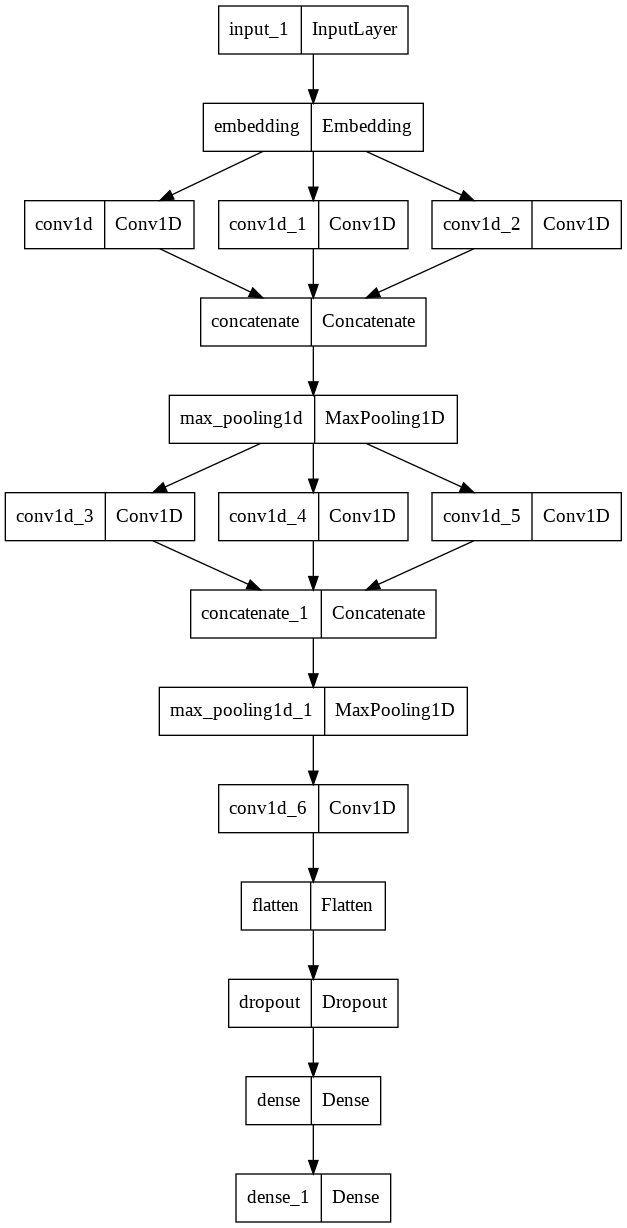

In [ ]:
# first input model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import plot_model

input = Input(shape=(max_length,))

#embeddings_initializer= tf.keras.initializers.HeUniform(seed=0),
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(input)

conv1D_m_filter = Conv1D(4, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(embedding)
conv1D_n_filter = Conv1D(8, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(embedding)
conv1D_o_filter = Conv1D(16, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(embedding)

concatenate_layer_1 = concatenate([conv1D_m_filter, conv1D_n_filter, conv1D_o_filter])

max_pool_layer_1 = MaxPooling1D()(concatenate_layer_1)

conv1D_i_filter = Conv1D(4, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(max_pool_layer_1)
conv1D_j_filter = Conv1D(8, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(max_pool_layer_1)
conv1D_k_filter = Conv1D(16, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(max_pool_layer_1)

concatenate_layer_2 = concatenate([conv1D_i_filter, conv1D_j_filter, conv1D_k_filter])

max_pool_layer_2 = MaxPooling1D()(concatenate_layer_2)

conv1D_p_filter = Conv1D(16, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(max_pool_layer_2)

flat1 = Flatten()(conv1D_p_filter)

droupout = Dropout(0.2)(flat1)

dense = Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(droupout)

output = Dense(20, activation='softmax', kernel_initializer='glorot_uniform')(dense)

model = Model(inputs=input, outputs=output)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='convolutional_neural_network.png')


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
padded_docs

array([[  19,    1, 2731, ...,    0,    0,    0],
       [  27,    1,   55, ...,    0,    0,    0],
       [   7, 2613,   11, ...,    0,    0,    0],
       ...,
       [1125, 1108,   73, ...,    0,    0,    0],
       [  36, 3466,    1, ...,    0,    0,    0],
       [  27,   27,   27, ...,    0,    0,    0]], dtype=int32)

In [ ]:
padded_docs.shape

(14121, 9013)

In [ ]:
padded_docs_test.shape

(4707, 9013)

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
history_own=LossHistory(model, padded_docs, y_train, padded_docs_test, y_test)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(padded_docs, y_train, epochs=25, verbose=2,
          validation_data=(padded_docs_test, y_test),
          callbacks = [earlystop,reduce_lr,terminateNAN,checkpoint,tensorboard_callback_1,history_own]
          )

Epoch 1/25

Epoch 00001: val_accuracy improved from -inf to 0.39409, saving model to /content/model_save/weights_Model_1_best.hdf5
Micro F1 Score : 0.26777142857142855 		 Validation Micro F1 Score : 0.24226715050976327
442/442 - 38s - loss: 2.3171 - accuracy: 0.2336 - val_loss: 1.6959 - val_accuracy: 0.3941 - lr: 0.0010 - 38s/epoch - 86ms/step
Epoch 2/25

Epoch 00002: val_accuracy improved from 0.39409 to 0.59061, saving model to /content/model_save/weights_Model_1_best.hdf5
Micro F1 Score : 0.5976334085363046 		 Validation Micro F1 Score : 0.5329593267882188
442/442 - 38s - loss: 1.3760 - accuracy: 0.5252 - val_loss: 1.2288 - val_accuracy: 0.5906 - lr: 0.0010 - 38s/epoch - 85ms/step
Epoch 3/25

Epoch 00003: val_accuracy improved from 0.59061 to 0.64563, saving model to /content/model_save/weights_Model_1_best.hdf5
Micro F1 Score : 0.7055204238591694 		 Validation Micro F1 Score : 0.6244484817025694
442/442 - 37s - loss: 1.0354 - accuracy: 0.6485 - val_loss: 1.0857 - val_accuracy: 0.64

**As we can see that in only 18 epochs, the validation accuracy is 71% whereas the accuracy on the train data is 95%. <br> Also, the train loss is 0.14 while the validation loss is 1.55. <br> The Micro F1 score on train data is 0.98 while on Validation Data is 0.71. <br>
Seeing the Micro F1 Score, we can safely say that the models don't overfit.**

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/model_save/Model_1/

**Below is the accuracy plot for train and validation data**

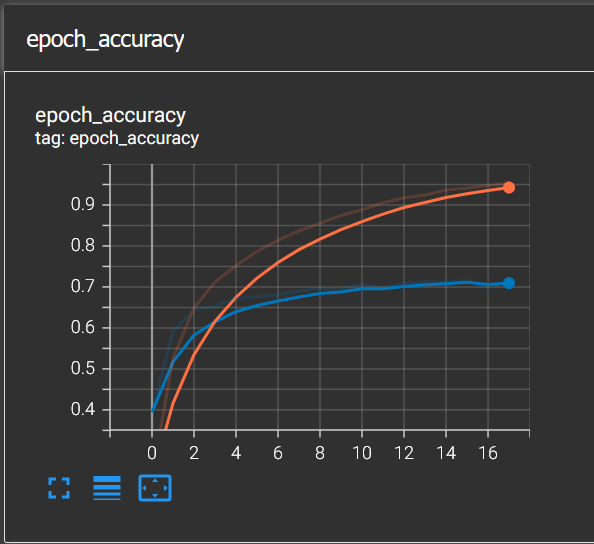

**Below is the categorical cross-entropy loss plot for train and validation data**

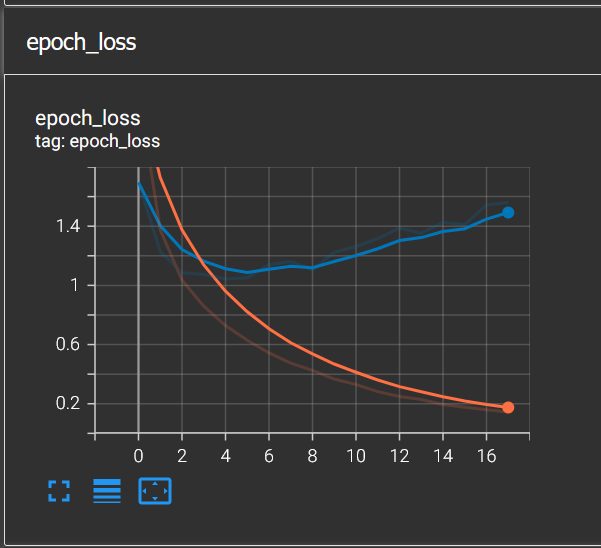

<h3>2.3.8. Second Model Using 1D convolutions with Character Embedding<h3>

In [ ]:
#Reference: https://towardsdatascience.com/character-level-cnn-with-keras-50391c3adf33
# construct a new vocabulary
alphabet = "abcdefghijklmnopqrstuvwxyz_"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

In [ ]:
# Apply Tokenizer on Train data (char_level is set to true)
#Removing _ from the default filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tk_char = Tokenizer(num_words=None, char_level=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tk_char.fit_on_texts(X_train)

In [ ]:
# Use char_dict to replace the tk.word_index
tk_char.word_index = char_dict.copy()

In [ ]:
encoded_docs_char_embedding = tk_char.texts_to_sequences(X_train)
encoded_docs_char_embedding_test = tk_char.texts_to_sequences(X_test)

In [ ]:
#Finding the maximum length
max_length_char_embedding = max([len(item) for item in encoded_docs_char_embedding])
max_length_char_embedding

48277

In [ ]:
len(encoded_docs_char_embedding[0])

589

**So, we are increasing the length from 589 to 48277**<br>
**Here, we are post-padding to the maximum length so that no data is lost.**

In [ ]:
len(encoded_docs_char_embedding)

14121

In [ ]:
len(encoded_docs_char_embedding[0])

589

In [ ]:
# Padding
padded_docs_char_embedding = pad_sequences(encoded_docs_char_embedding, maxlen=max_length_char_embedding, padding='post')
padded_docs_char_embedding_test = pad_sequences(encoded_docs_char_embedding_test, maxlen=max_length_char_embedding, padding='post')

In [ ]:
padded_docs_char_embedding.shape

(14121, 48277)

In [ ]:
padded_docs_char_embedding_test.shape

(4707, 48277)

In [ ]:
vocab_size = len(tk_char.word_index)
vocab_size

27

In [ ]:
#Creating the embedding matrix for the character embedding
embedding_weights_char = []
embedding_weights_char.append(np.zeros(vocab_size))

for char, i in tk_char.word_index.items():
  onehot = np.zeros(vocab_size)
  onehot[i-1] = 1
  embedding_weights_char.append(onehot)
embedding_weights_char = np.array(embedding_weights_char)

In [ ]:
embedding_weights_char.shape

(28, 27)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48277)]           0         
                                                                 
 embedding_1 (Embedding)     (None, 48277, 27)         756       
                                                                 
 conv1d_7 (Conv1D)           (None, 48274, 4)          436       
                                                                 
 conv1d_8 (Conv1D)           (None, 48271, 8)          136       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 24135, 8)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 24132, 4)          132       
                                                           

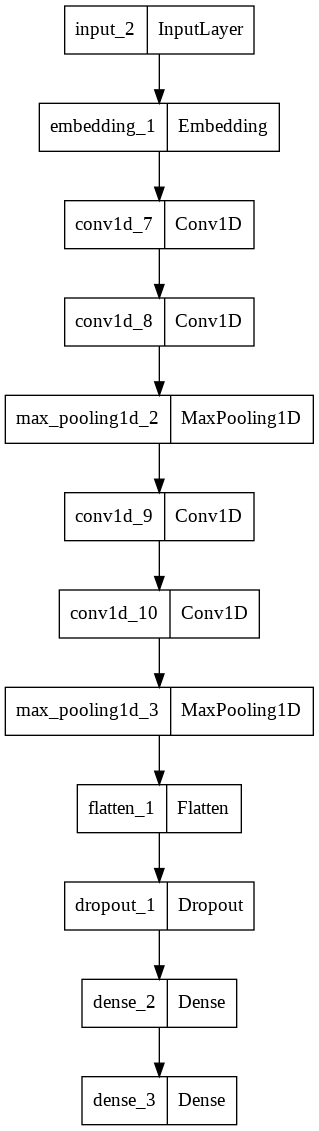

In [ ]:
#Creating the model
input = Input(shape=(max_length_char_embedding,))

#embeddings_initializer= tf.keras.initializers.HeUniform(seed=0),
embedding = Embedding(vocab_size+1, 27, weights=[embedding_weights_char], input_length=max_length_char_embedding, trainable=False)(input)

conv1D_m_filter = Conv1D(4, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(embedding)
conv1D_n_filter = Conv1D(8, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(conv1D_m_filter)

max_pool_layer_1 = MaxPooling1D()(conv1D_n_filter)

conv1D_i_filter = Conv1D(4, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(max_pool_layer_1)
conv1D_j_filter = Conv1D(8, kernel_size=4, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(conv1D_i_filter)

max_pool_layer_2 = MaxPooling1D()(conv1D_j_filter)

flat1 = Flatten()(max_pool_layer_2)

droupout = Dropout(0.2)(flat1)

dense = Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=0))(droupout)

output = Dense(20, activation='softmax', kernel_initializer='glorot_uniform')(dense)

model2 = Model(inputs=input, outputs=output)

# summarize layers
print(model2.summary())

# plot graph
plot_model(model2, to_file='convolutional_neural_network_char_embedding.png')


In [ ]:
history_own2=LossHistory(model2, padded_docs_char_embedding, y_train, padded_docs_char_embedding_test, y_test)

In [ ]:
#Setting the filepath where we will store the models
filepath="/content/model_save/weights_Model_2_best.hdf5"

#Creating Model Checkout when val_accuracy has not improved 
checkpoint2 = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(padded_docs_char_embedding, y_train, epochs=10, verbose=2,
          validation_data=(padded_docs_char_embedding_test, y_test),
          callbacks = [earlystop,reduce_lr,terminateNAN,checkpoint2,tensorboard_callback_2,history_own2]
          )

Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.07733, saving model to /content/model_save/weights_Model_2_best.hdf5
Micro F1 Score : 0.00042477876106194687 		 Validation Micro F1 Score : 0.0
442/442 - 24s - loss: 2.9569 - accuracy: 0.0719 - val_loss: 2.9356 - val_accuracy: 0.0773 - lr: 0.0010 - 24s/epoch - 55ms/step
Epoch 2/10

Epoch 00002: val_accuracy improved from 0.07733 to 0.08902, saving model to /content/model_save/weights_Model_2_best.hdf5
Micro F1 Score : 0.0025452488687782806 		 Validation Micro F1 Score : 0.0004246284501061571
442/442 - 23s - loss: 2.9073 - accuracy: 0.0872 - val_loss: 2.9036 - val_accuracy: 0.0890 - lr: 0.0010 - 23s/epoch - 53ms/step
Epoch 3/10

Epoch 00003: val_accuracy improved from 0.08902 to 0.11812, saving model to /content/model_save/weights_Model_2_best.hdf5
Micro F1 Score : 0.0033898305084745766 		 Validation Micro F1 Score : 0.0
442/442 - 23s - loss: 2.7750 - accuracy: 0.1172 - val_loss: 2.7224 - val_accuracy: 0.1181 - lr: 0.0010 - 2

**As we can see that in only 7 epochs, the validation accuracy is 14% whereas the accuracy on the train data is 20%. <br> Also, the train loss is 2.42 while the validation loss is 2.68. <br> The Micro F1 score on train data is 0.05 while on Validation Data is 0.009. <br>
Seeing the above scores, we can safely say that the models don't overfit.**

In [ ]:
%tensorboard --logdir /content/model_save/Model_2/

**Below is the accuracy plot for train and validation data**

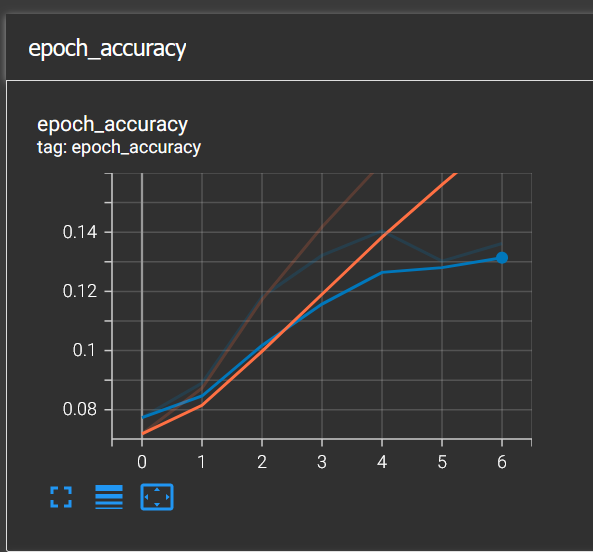

**Below is the loss plot for train and validation data**

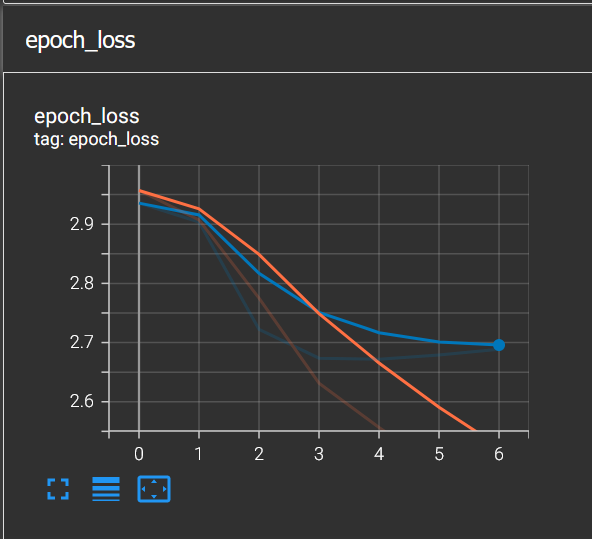

<h2>3. Summary<h2>

In [61]:
summary = PrettyTable(["Model", "Validation Accuracy", "Validation Log Loss", "Validation Micro F1 score"])
summary.add_row(["Model 1 (CNN with Word Embedding)", "70%", "1.55", "0.71"])
summary.add_row(["Model 2 (CNN with Character Embedding)", "14%", "2.68", "0.009"])
print(summary)

+----------------------------------------+---------------------+---------------------+---------------------------+
|                 Model                  | Validation Accuracy | Validation Log Loss | Validation Micro F1 score |
+----------------------------------------+---------------------+---------------------+---------------------------+
|   Model 1 (CNN with Word Embedding)    |         70%         |         1.55        |            0.71           |
| Model 2 (CNN with Character Embedding) |         14%         |         2.68        |           0.009           |
+----------------------------------------+---------------------+---------------------+---------------------------+


**Thus, we can say that the model (CNN using word embedding) worked better than the model (CNN using character embedding).**